In [1]:
from functools import partial

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from models.data import JSRTDataModule, CheXpertDataModule, CLEVRNDataset
from models.mae.mae import ViTAE
from models.encoders import CNNEncoder, ResNet34_8x8, get_resnet34_encoder, DinoViT_16, Dinov2ViT_14, DinoViT_8
from models.segmentation import ObjectSpecificSegmentation

from pytorch_lightning.loggers import WandbLogger
from pathlib import Path

In [27]:
# saved_model = ViTAE.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/lightning_logs/chestxray_mae/chestxray_mae/gn9nzdz8/checkpoints/epoch=503-step=95256.ckpt',
#     model_kwargs={
#         'img_size': 224,
#         'embed_dim': 768,
#         'in_chans': 1,
#         'num_heads': 12,
#         'depth': 12,
#         'decoder_embed_dim': 512,
#         'decoder_depth': 8,
#         'decoder_num_heads': 16,
#         'norm_layer': partial(nn.LayerNorm, eps=1e-6),
#         'mlp_ratio': 4.0,
#         'patch_size': 16,
#         'norm_pix_loss': False,
#     },
#     learning_rate=1e-4,
#     map_location=torch.device('cpu'),
#     )

In [28]:
# saved_model = ViTAE(
#     model_kwargs={
#         'img_size': 224,
#         'embed_dim': 768,
#         'in_chans': 3,          # for clevr
#         'num_heads': 12,
#         'depth': 12,
#         'decoder_embed_dim': 512,
#         'decoder_depth': 8,
#         'decoder_num_heads': 16,
#         'norm_layer': partial(nn.LayerNorm, eps=1e-6),
#         'mlp_ratio': 4.0,
#         'patch_size': 16,
#         'norm_pix_loss': False,
#         'mask_ratio': 0.75,
#     },
#     learning_rate=1e-4,
# )

In [86]:
encoder = DinoViT_8()

# CNN
# oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/chexray_final/chexray_final/42_cnn_seg/checkpoints/epoch=4399-step=61600.ckpt',
#                                 encoder=encoder, num_slots=4, num_iterations=3, num_classes=4, 
#                                  slot_dim=128, decoder_type='cnn', 
#                                  learning_rate=1e-4, freeze_encoder=True, temperature=1, 
#                                  log_images=True, lr_warmup=True, include_seg_loss=True,
#                                  slot_attn_type='probabilistic', probabilistic_sample=True, image_chans=1, 
#                                  image_resolution=224, 
#                                  embedding_dim=384, embedding_shape=(28, 28),
#                                  include_pos_embed=True, patch_size=8, num_patches=784,
#                                  slot_attn_heads=4, decoder_blocks=4, decoder_heads=8, 
#                                  decoder_dim=64, autoregressive=False, label_smoothing=0.0)

# Add T
# oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/chexray_final/chexray_final/42_t_seg/checkpoints/epoch=1279-step=17920.ckpt',
#                                 encoder=encoder, num_slots=4, num_iterations=3, num_classes=4, 
#                                  slot_dim=128, decoder_type='transformer', 
#                                  learning_rate=1e-4, freeze_encoder=True, temperature=1, 
#                                  log_images=True, lr_warmup=True, include_seg_loss=True,
#                                  slot_attn_type='probabilistic', probabilistic_sample=True, image_chans=1, 
#                                  image_resolution=224, 
#                                  embedding_dim=384, embedding_shape=(28, 28),
#                                  include_pos_embed=True, patch_size=8, num_patches=784,
#                                  slot_attn_heads=4, decoder_blocks=6, decoder_heads=8, 
#                                  decoder_dim=256, autoregressive=False, label_smoothing=0.0)

# AR T
oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/chexray_final/chexray_final/42_art_no_sample_2_retrain/checkpoints/epoch=2239-step=8960.ckpt',
                                encoder=encoder, num_slots=4, num_iterations=3, num_classes=4, 
                                 slot_dim=128, decoder_type='transformer', 
                                 learning_rate=1e-4, freeze_encoder=True, temperature=1, 
                                 log_images=True, lr_warmup=True, include_seg_loss=True,
                                 slot_attn_type='probabilistic', probabilistic_sample=True, image_chans=1, 
                                 image_resolution=224, 
                                 embedding_dim=384, embedding_shape=(28, 28),
                                 include_pos_embed=True, patch_size=8, num_patches=784,
                                 slot_attn_heads=4, decoder_blocks=6, decoder_heads=8, 
                                 decoder_dim=256, autoregressive=True, label_smoothing=0.0)

Using cache found in /homes/bc1623/.cache/torch/hub/facebookresearch_dino_main
/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [87]:
#data = CLEVRNDataset(batch_size=32)
data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=8, augmentation=True, random_seed=42)
data_chex = CheXpertDataModule(data_dir='/vol/biodata/data/chest_xray/CheXpert-v1.0/preproc_224x224/', batch_size=16, cache=False, augmentation=False)

True


Loading Data: 100%|██████████| 25/25 [00:00<00:00, 24110.74it/s]


Loading Data: 100%|██████████| 25424/25424 [00:00<00:00, 1017043.41it/s]


In [4]:
# find train batch size
batch = next(iter(data.train_dataloader()))
print(len(batch['image']))

16


In [ ]:
#oss.include_seg_loss = True
# # # freeze oss decoder
#oss.decoder.requires_grad_(True)
#oss.freeze_encoder = False
# oss.decoder.requires_grad_(True)
# oss.learning_rate = 0.1
# oss.label_smoothing = 0.0

In [ ]:
# from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(save_dir='./runs/lightning_logs/obj_centric_chest_seg/', project='probabilistic_seg',
                           name='dino_unsup_3', id='dino_unsup_3', offline=False)
output_dir = Path(f"obj_centric_chest_seg/run_{wandb_logger.experiment.id}")  # type: ignore
print("Saving to" + str(output_dir.absolute()))

trainer = Trainer(
    max_epochs=2500,
    precision='16-mixed',
    accelerator='auto',
    devices=[0],
    #strategy='ddp_notebook',
    # log_every_n_steps=250,
    val_check_interval=0.25,
    # check_val_every_n_epoch=0.25,
    # #save_top_k=1,
    logger=wandb_logger,
    # callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)],
)
torch.set_float32_matmul_precision('medium')

trainer.fit(model=oss, datamodule=data)

# trainer.validate(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# trainer.test(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Text(0.5, 1.0, 'probability map')

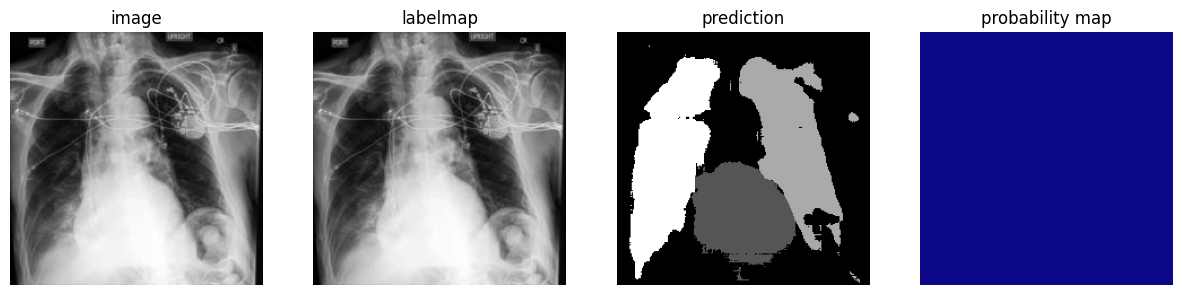

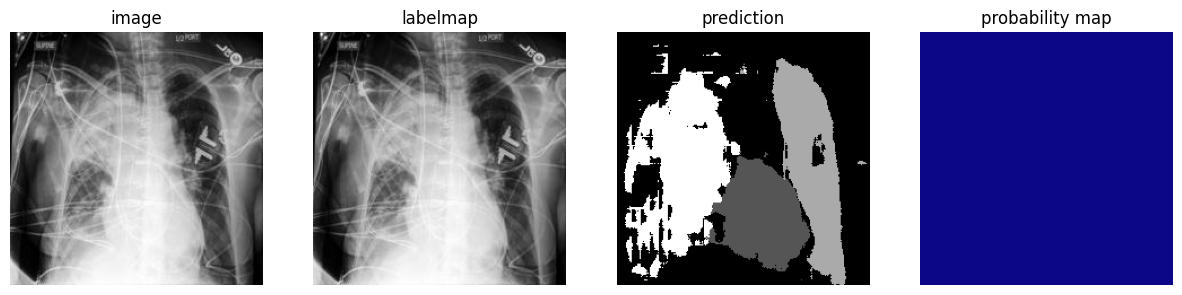

In [88]:
image_num = 6
oss.num_iterations = 6
batch = next(iter(data_chex.test_dataloader()))
cuda_device = torch.device('cuda:0')
import numpy as np
oss.include_seg_loss = False
# vertical flip batch
# batch['image'] = torch.flip(batch['image'], [2])
# batch['labelmap'] = torch.flip(batch['labelmap'], [2])

batch['image'] = batch['image']#[:2]
# batch['labelmap'] = batch['labelmap']#[:2]
# move to gpu
batch = {k: v.to(cuda_device) for k, v in batch.items()}
# oss.to(cuda_device)

with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['image'][image_num].squeeze().cpu()
probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()
# predmap = np.transpose(predmap, (1, 2, 0))

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap[image_num, ...], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('probability map')

image_num += 1
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['image'][image_num].squeeze().cpu()
probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()
# predmap = np.transpose(predmap, (1, 2, 0))

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap[image_num, ...], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('probability map')

In [29]:
# # plot attention matrix
# image_num = 0
# attn = oss.attn[image_num].cpu().detach().numpy()   
# # slot 0
# # slot_0_attn = attn[0, :]
# # slot_0_attn = slot_0_attn.reshape(14, 14)

# f, ax = plt.subplots(1, attn.shape[0], figsize=(15, 15))

# for slot in range(attn.shape[0]):
#     slot_attn = attn[slot, :]
#     slot_attn = slot_attn.reshape(14, 14)
#     ax[slot].imshow(slot_attn, cmap=matplotlib.cm.gray)
#     ax[slot].axis('off')
#     ax[slot].set_title(f'slot {slot}')

In [89]:
# calculate entropy of predictions
cuda_device = 'cuda:0'
image_num = 6
trials = 500
oss.probabilistic_sample = True
batch = next(iter(data_chex.test_dataloader()))
oss.include_seg_loss = False
# batch['image'] = batch['image'][:2]
# batch['labelmap'] = batch['labelmap'][:2]

list_entropy = []
#all_preds = torch.empty((batch['image'].shape[0], 224, 224), dtype=torch.long)
oss.to(cuda_device)
batch = {k: v.to(cuda_device) for k, v in batch.items()}
for _ in range(trials):
    with torch.no_grad():
        loss, dsc, probs, preds, _, _, _, _ = oss.process_batch(batch, 1)
        # preds = torch.argmax(preds, dim=1)
        list_entropy.append(preds)

all_preds = torch.stack(list_entropy, dim=1)
oss.to('cpu')
del batch
print(all_preds.shape)

torch.Size([16, 500, 1, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

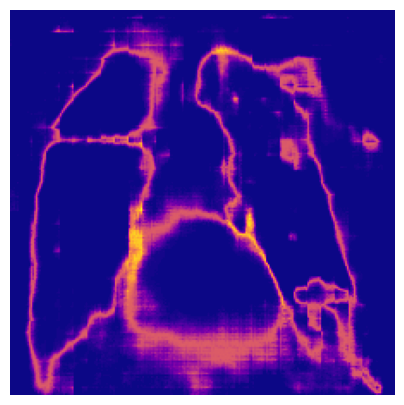

In [90]:
def calculate_class_entropy(predictions):

    N, H, W = predictions.shape
    num_classes = predictions.max().item() + 1 
    
    # one-hot encoding
    one_hot = torch.zeros(N, num_classes, H, W, device=predictions.device)
    one_hot.scatter_(1, predictions.unsqueeze(1), 1)
    
    class_counts = one_hot.sum(dim=0)  # shape (num_classes, H, W)
    
    probabilities = class_counts / N
    
    probabilities = torch.clamp(probabilities, 1e-7, 1 - 1e-7)
    
    entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=0)
    
    return entropy

# Example usage
# Assuming 'stacked_predictions' is your tensor of shape (N, H, W)
image_num = 6
pixel_entropy = calculate_class_entropy(all_preds[image_num, ...].squeeze()).cpu()

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(pixel_entropy, cmap='plasma')
ax.axis('off')
# ax.set_title('Entropy Map')

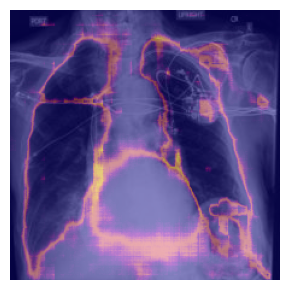

: 

In [91]:
image_num = 6
image = image.squeeze().cpu()
batch = next(iter(data_chex.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()

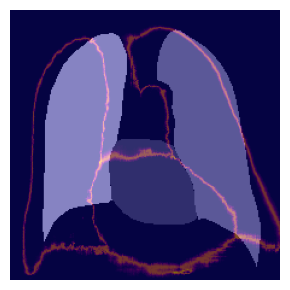

In [84]:
image_num = 6
image = image.squeeze().cpu()
batch = next(iter(data.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['labelmap'][image_num].squeeze().cpu() * 255, cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()